In [1]:
import scipy.io as sio
from control import matlab
from control import impulse_response, rss, drss
import numpy as np
import matplotlib.pyplot as plt
from math import floor
from scipy.linalg import fractional_matrix_power
from numpy.linalg import multi_dot
import scipy

In [2]:
q = 2 # number of inputs
p = 2 # number of outputs
n = 500 # number of states
sysFull = rss(n, p, q, strictly_proper=True)
sysFull_poles = matlab.pole(sysFull).real
sysFull_poles[sysFull_poles>0]

array([], dtype=float64)

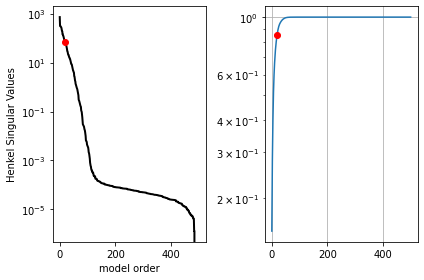

In [3]:
r = 20
hsvs = matlab.hsvd(sysFull)
hsvs = hsvs.real
plt.subplot(121)
plt.semilogy(hsvs, 'k', linewidth=2)
plt.semilogy(r, hsvs[r], 'ro', linewidth=2)
plt.xlabel('model order')
plt.ylabel('Henkel Singular Values')
plt.subplot(122)
plt.plot(np.arange(0, len(hsvs)), np.array(np.cumsum(hsvs)/np.sum(hsvs)))
plt.semilogy(r, np.sum(hsvs[0: r])/np.sum(hsvs), 'ro', linewidth=2)
plt.tight_layout()
plt.grid()
plt.show()

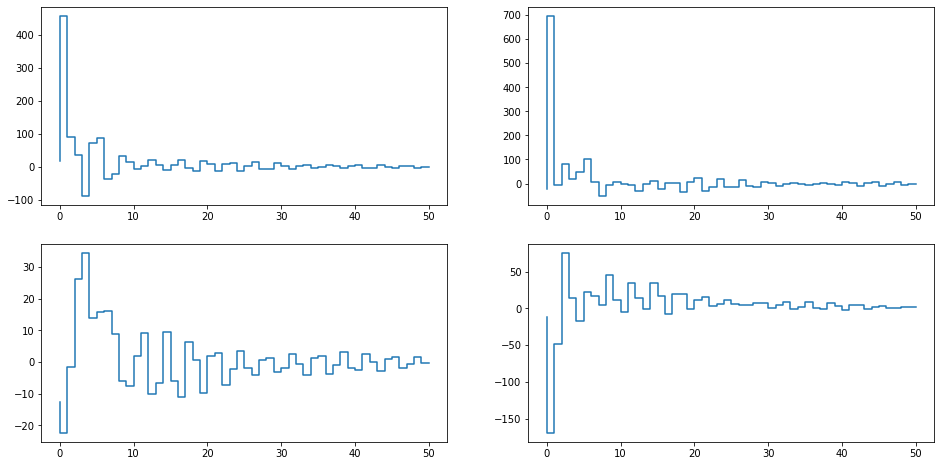

In [4]:
tFull, yFull = impulse_response(sysFull, T=np.arange(0, 51, 1))

plt.figure(figsize=(16, 8))

plt.subplot(221)
plt.step(tFull, yFull[0, 0, :])

plt.subplot(223)
plt.step(tFull, yFull[1, 0, :])

plt.subplot(222)
plt.step(tFull, yFull[0, 1, :])

plt.subplot(224)
plt.step(tFull, yFull[1, 1, :])

plt.show()

In [8]:
def ERA_calc(YY, m, n, nin, nout, r):
    Dr = np.zeros((nout, nin))
    y = np.zeros((nout, nin, YY.shape[2]-1))
    m = n = mco
    for i in range(0, nout):
        for j in range(0, nin):
            Dr[i, j] = YY[i, j, 0]
            y[i, j, :] = YY[i, j, 1:]
            
    assert y[:, 0, 0].shape[0]==nout
    assert y[0, :, 0].shape[0]==nin
    assert y[0, 0, :].shape[0]==(m+n)
    
    H = np.zeros((m*nout, n*nin))
    H2 = np.zeros((m*nout, n*nin))
    for i in range(0, m):
        for j in range(0, n):
            for Q in range(0, nout):
                for P in range(0, nin):
                    H[nout*i + Q, nin*j + P] = y[Q, P, i+j]
                    H2[nout*i + Q, nin*j + P] = y[Q, P, i+j+1]
    
    U, sig, V = scipy.linalg.svd(H)
    HSVs = sig
    sigma_H = np.diag(sig)
    sigma_H_r = sigma_H[0:r, 0:r]
    Ur = U[:, 0:r]
    Vr = np.matrix.transpose(V)[:, 0:r]
    Ar = multi_dot([fractional_matrix_power(sigma_H_r, -0.5), np.matrix.transpose(Ur), H2, Vr, fractional_matrix_power(sigma_H_r, -0.5)])
    Br = multi_dot([fractional_matrix_power(sigma_H_r, -0.5), np.matrix.transpose(Ur), H[:, 0:nin]])
    Cr = multi_dot([H[0:nout, :], Vr, fractional_matrix_power(sigma_H_r, -0.5)])
    
    return Ar, Br, Cr, Dr, HSVs, H, H2, sigma_H_r, U, V, Ur, Vr

In [10]:
YY = yFull
mco = floor((yFull.shape[2]-1)/2)
Ar, Br, Cr, Dr, HSVs, H, H2, Sigma, U, V, Ur, Vr = ERA_calc(YY, mco, mco, q, p, r)
sysERA = matlab.ss(Ar, Br, Cr, Dr, 1)

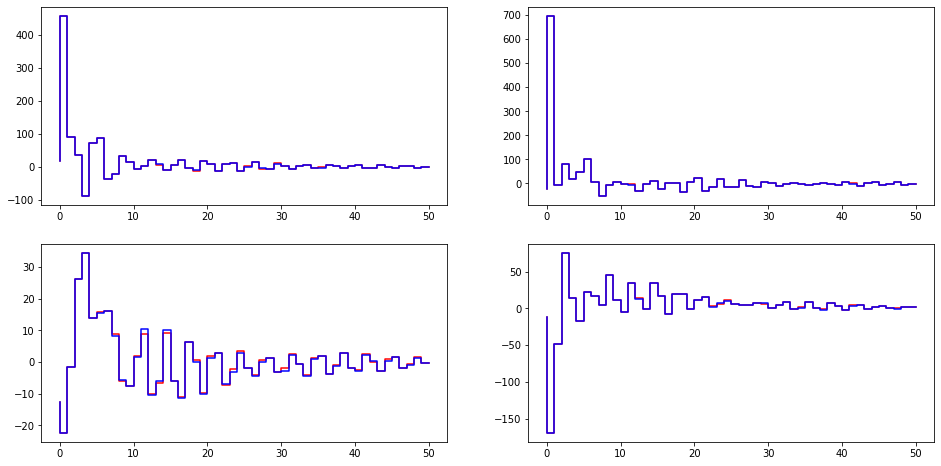

In [11]:
tFull, yFull = impulse_response(sysFull, T=np.arange(0, 51, 1))
tERA, yERA = impulse_response(sysERA, T=np.arange(0, 51, 1))

plt.figure(figsize=(16, 8))

plt.subplot(221)
plt.step(tFull, yFull[0, 0, :], 'r')
plt.step(tERA, yERA[0, 0, :], 'b')

plt.subplot(223)
plt.step(tFull, yFull[1, 0, :], 'r')
plt.step(tERA, yERA[1, 0, :], 'b')

plt.subplot(222)
plt.step(tFull, yFull[0, 1, :], 'r')
plt.step(tERA, yERA[0, 1, :], 'b')

plt.subplot(224)
plt.step(tFull, yFull[1, 1, :], 'r')
plt.step(tERA, yERA[1, 1, :], 'b')

plt.show()